# Health Monitoring - FOODS 2 Item Sales (Target)

This notebook provides comprehensive monitoring for the target variable's health. It includes data quality checks, statistical tests, and visualizations.

## 1. Setup & Configuration

Import required libraries and set up parameters.

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ks_2samp
import ruptures as rpt
import sys
import os

# --- Imports from project root ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "..", ".."))
sys.path.append(project_root)
from src.core.clients.bigquery import BigQueryClient

# --- Plotting style ---
sns.set(style='whitegrid', context='notebook')

In [2]:
# --- Load Data From BigQuery ---
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
        AND tgt.ctx_dept_id = 'FOODS_2'
"""


# Extract data
df = bq_client.load_from_query(sales_query)

# Define target name to analyze:
target_name = "tgt_monthly_sales_sum_3_next_months"

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 17879 rows from custom query.


## 2. Data Quality Checks

In [3]:
# Check for missing values
missing_summary = df.isnull().sum()
print('Missing values per column:')
print(missing_summary)

# Check for duplicates at expected granularity
duplicates = df.duplicated(subset=['ctx_date_month', 'ctx_item_id', 'ctx_dept_id'])
num_duplicates = duplicates.sum()
if num_duplicates > 0:
    print(f'Found {num_duplicates} duplicate records.')
else:
    print('No duplicate records found at the expected granularity.')

Missing values per column:
ctx_date_month                         0
ctx_cat_id                             0
ctx_dept_id                            0
ctx_item_id                            0
tgt_monthly_sales                      0
tgt_monthly_sales_sum_3_next_months    0
dtype: int64
No duplicate records found at the expected granularity.


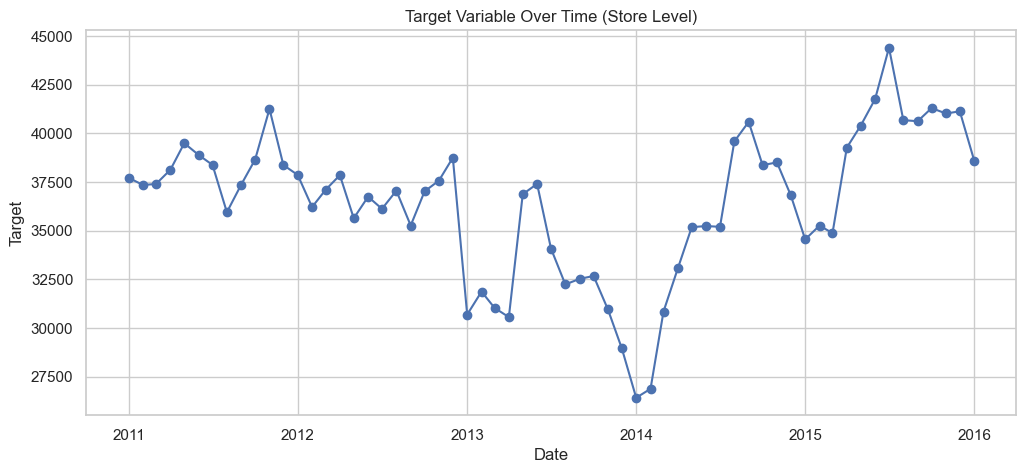

In [4]:
# Aggregate at store level (or by department/item as needed)
df_store = df.groupby('ctx_date_month')[target_name].sum().sort_index()

# Plot target variable over time
plt.figure(figsize=(12, 5))
plt.plot(df_store.index, df_store.values, marker='o')
plt.title('Target Variable Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.show()

## 3. Stationarity Analysis

Apply Augmented Dickey-Fuller (ADF) and KPSS tests to assess stationarity.

In [5]:
def run_stationarity_tests(series):
    """Run ADF and KPSS tests and print results."""
    adf_result = adfuller(series)
    print(f'ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3f}')
    kpss_result = kpss(series, regression='ct', nlags='auto')
    print(f'KPSS Statistic: {kpss_result[0]:.3f}, p-value: {kpss_result[1]:.3f}')

run_stationarity_tests(df_store)

ADF Statistic: -2.340, p-value: 0.160
KPSS Statistic: 0.243, p-value: 0.010


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_61419/3472232138.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='ct', nlags='auto')


## 4. Change Point Detection

2016-01-01


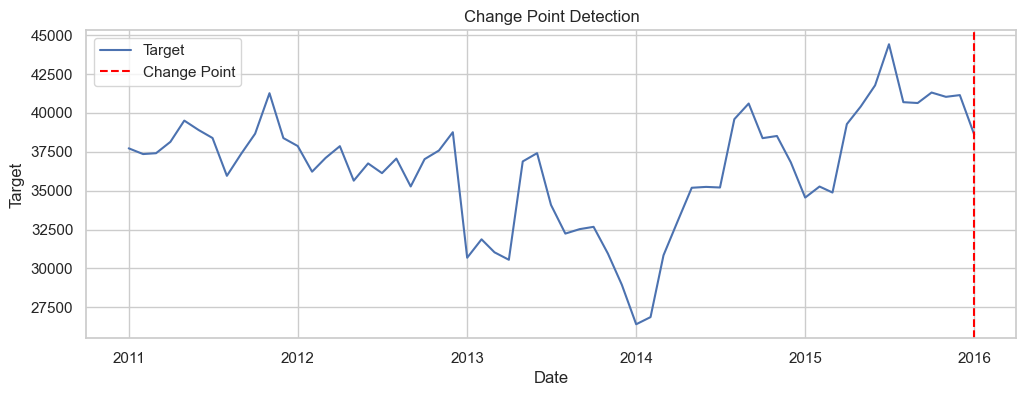

In [6]:
# Detect change points in the target variable
ts = df_store.values
algo = rpt.Pelt(model='rbf').fit(ts)
result = algo.predict(pen=10)

plt.figure(figsize=(12, 4))
plt.plot(df_store.index, ts, label='Target')
for i, cp in enumerate(result):
    plt.axvline(df_store.index[cp-1], color='red', linestyle='--', label='Change Point' if i == 0 else None)
    print(df_store.index[cp-1])
plt.title('Change Point Detection')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()

plt.show()

## 5. Autocorrelation Analysis

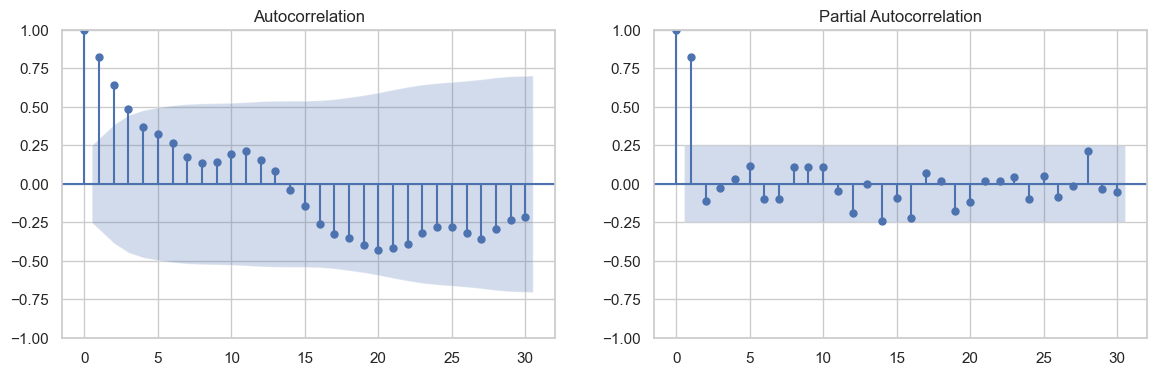

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_store, ax=axes[0], lags=30)
axes[0].set_title('Autocorrelation')
plot_pacf(df_store, ax=axes[1], lags=30)
axes[1].set_title('Partial Autocorrelation')
plt.show()

## 6. Data Drift Monitoring

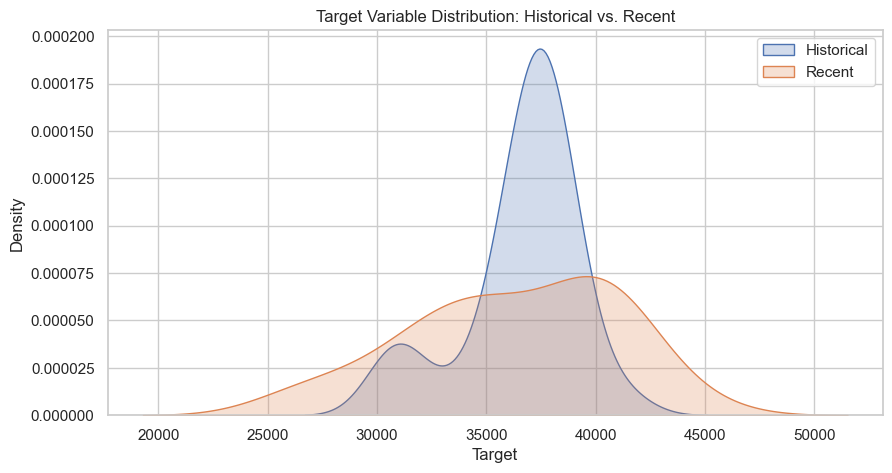

KS Statistic: 0.339, p-value: 0.050


In [8]:
# Compare recent vs. historical distributions
historical = df_store[:-30]
recent = df_store[-30:]

plt.figure(figsize=(10, 5))
sns.kdeplot(historical, label='Historical', fill=True)
sns.kdeplot(recent, label='Recent', fill=True)
plt.title('Target Variable Distribution: Historical vs. Recent')
plt.xlabel('Target')
plt.legend()
plt.show()

# Kolmogorov-Smirnov test
ks_stat, ks_p = ks_2samp(historical, recent)
print(f'KS Statistic: {ks_stat:.3f}, p-value: {ks_p:.3f}')

## 7. ARIMA and SARIMA Modeling

Fit ARIMA and SARIMA models to the aggregated target time series (`df_store`).

                                        SARIMAX Results                                        
Dep. Variable:     tgt_monthly_sales_sum_3_next_months   No. Observations:                   61
Model:                                  ARIMA(1, 1, 1)   Log Likelihood                -546.885
Date:                                 Wed, 21 Jan 2026   AIC                           1099.770
Time:                                         15:25:52   BIC                           1106.053
Sample:                                     01-01-2011   HQIC                          1102.227
                                          - 01-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9172      0.212      4.318      0.000       0.501       1

/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('No

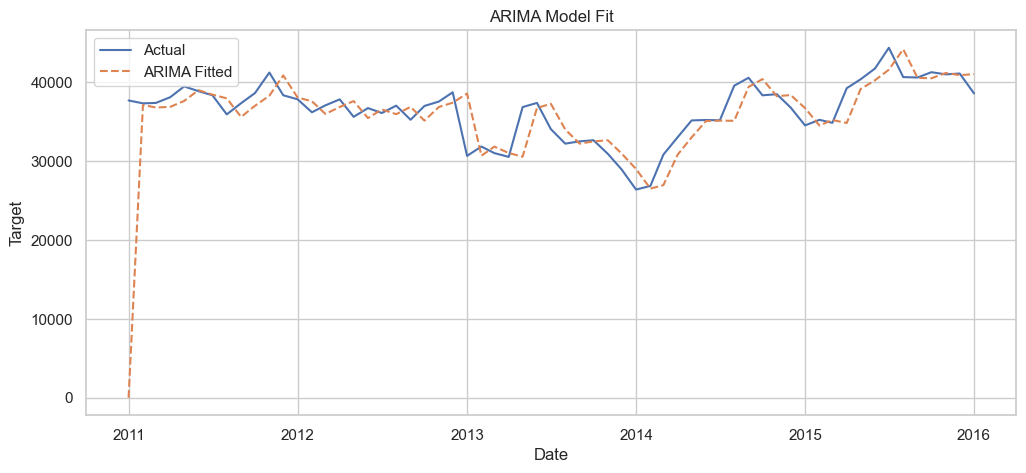

In [9]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA (order can be tuned or selected via auto_arima)
arima_model = ARIMA(df_store, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Plot ARIMA fitted values
plt.figure(figsize=(12,5))
plt.plot(df_store.index, df_store.values, label='Actual')
plt.plot(df_store.index, arima_result.fittedvalues, label='ARIMA Fitted', linestyle='--')
plt.title('ARIMA Model Fit')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:     tgt_monthly_sales_sum_3_next_months   No. Observations:                   61
Model:                  SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -454.490
Date:                                 Wed, 21 Jan 2026   AIC                            918.980
Time:                                         15:25:52   BIC                            928.336
Sample:                                     01-01-2011   HQIC                           922.515
                                          - 01-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4454      1.393      0.320      0.749      -2.285       3

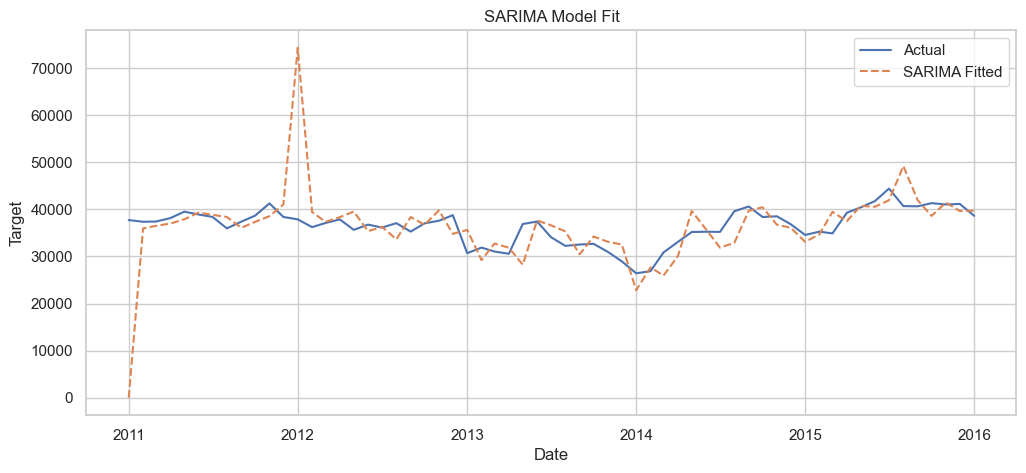

In [10]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example: SARIMA(1,1,1)x(1,1,1,12) for monthly data (adjust seasonal_order as needed)
sarima_model = SARIMAX(df_store, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

# Plot SARIMA fitted values
plt.figure(figsize=(12,5))
plt.plot(df_store.index, df_store.values, label='Actual')
plt.plot(df_store.index, sarima_result.fittedvalues, label='SARIMA Fitted', linestyle='--')
plt.title('SARIMA Model Fit')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

## 9. Model Error Metrics

Evaluate ARIMA and SARIMA model performance using common error metrics: MAE, RMSE, and MAPE.

In [11]:
# Calculate error metrics for ARIMA and SARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

# ARIMA metrics
arima_pred = arima_result.fittedvalues
mae_arima = mean_absolute_error(df_store, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(df_store, arima_pred))
mape_arima = mean_absolute_percentage_error(df_store, arima_pred)

# SARIMA metrics
sarima_pred = sarima_result.fittedvalues
mae_sarima = mean_absolute_error(df_store, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(df_store, sarima_pred))
mape_sarima = mean_absolute_percentage_error(df_store, sarima_pred)

print('ARIMA MAE:', mae_arima)
print('ARIMA RMSE:', rmse_arima)
print('ARIMA MAPE:', mape_arima)
print('SARIMA MAE:', mae_sarima)
print('SARIMA RMSE:', rmse_sarima)
print('SARIMA MAPE:', mape_sarima)

ARIMA MAE: 2202.9100649394977
ARIMA RMSE: 5298.990097690887
ARIMA MAPE: 6.082933009953613
SARIMA MAE: 3408.6679653439946
SARIMA RMSE: 7300.550884059933
SARIMA MAPE: 9.382145082847238
